In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.python.client import device_lib

config = tf.ConfigProto(allow_soft_placement=True, 
                        log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 

tf.keras.backend.set_session(sess)

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[u'/device:GPU:0']

In [2]:
def evaluate_model(model):
    model.summary()
    # evaluate the model using the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test loss: %.4f, accuracy: %.4f" % (test_loss, test_acc))

def visualize_loss_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_loss"], label="Validation loss")
    plt.plot(history["loss"], label="Training loss")
    plt.legend()

def visualize_accuracy_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_acc"], label="Validation accuracy")
    plt.plot(history["acc"], label="Training accuracy")
    plt.legend()

In [3]:
import json
import time

def save_history(history, filename):
    with open(filename + '_%s.json' % str(time.time()), 'w') as f:
        json.dump(history, f)

def load_history(filename):
    with open(filename) as json_file:  
        return json.load(json_file)
        
def save_weights(model, file):
    model.save_weights(file + "_%s.h5" % str(time.time()))
        
def join_histories(h1, h2):
    return {
        'acc': h1['acc'] + h2['acc'],
        'loss': h1['loss'] + h2['loss'],
        'val_acc': h1['val_acc'] + h2['val_acc'],
        'val_loss': h1['val_loss'] + h2['val_loss']
    }
        
# checkpoint
filepath="weights-improvement-mt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

## Analysis of the dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = x_train.shape[1:]
num_classes = np.unique(y_train).shape[0]

print("number of classes:", num_classes)
print("input shape:", input_shape)
print("Image data type:", x_train.dtype)

('x_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')
('number of classes:', 10)
('input shape:', (32, 32, 3))
('Image data type:', dtype('uint8'))


The dataset consists of 60000 images of size 32x32 pixels. The images are rgb (3 channels). There are 10 classes in the dataset.

### Visualisation of the dataset

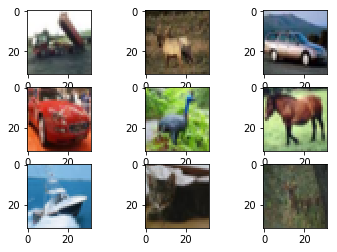

In [5]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 1])

(50000, 1)


<BarContainer object of 10 artists>

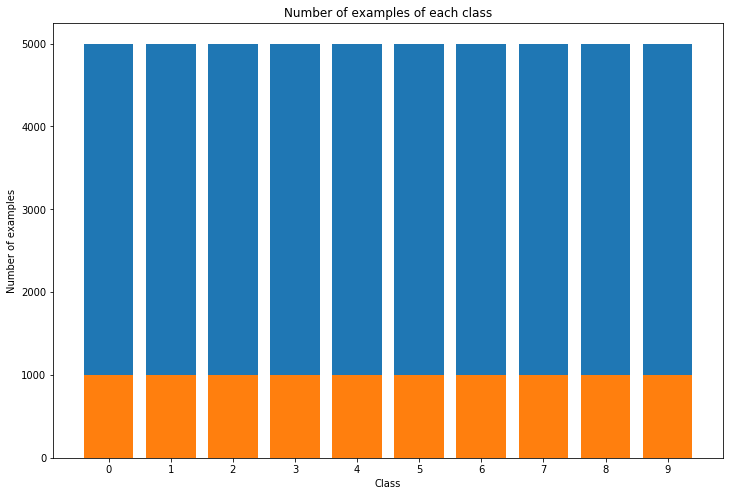

In [6]:
print(y_train.shape)
class_distribution_train = Counter(y_train[:,0])
class_distribution_test = Counter(y_test[:,0])
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The dataset is evenly distributed across the 10 classes.

### Normalize the dataset

In [7]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Split out validation data

In [8]:
train_val_split = 0.85 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val_data = x_train[idx_val]
y_val_data = y_train[idx_val]

x_train_data = x_train[idx_train]
y_train_data = y_train[idx_train]

print("Training images:", x_train_data.shape)
print("Validation images:", x_val_data.shape)
print("Test images:", x_test.shape)

('Training images:', (42500, 32, 32, 3))
('Validation images:', (7500, 32, 32, 3))
('Test images:', (10000, 32, 32, 3))


### Data augmentation

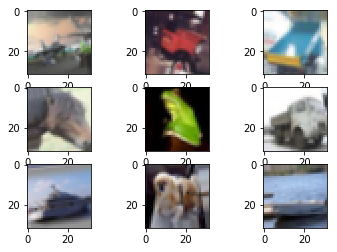

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_data)

for x_batch, y_batch in datagen.flow(x_train_data,
                                     y_train_data,
                                     batch_size=9):
    for i in range(0, 9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
    plt.show()
    break

Data augmentation rotates, shifts and flips the images, and gives us more varied training data, thus preventing overfitting

## Implementing a known model

### Model definition

In [39]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPool2D())

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.Dense(num_classes))
model1.add(tf.keras.layers.Activation('softmax'))

### Training the model

In [40]:
opt = 'adam'

model1.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model1_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

# checkpoint
filepath="model1-chkpnt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

### Without data augmentation

In [46]:
batch_size = 64
epochs = 10

h = model1.fit(x_train_data, y_train_data,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               callbacks=callbacks_list,
               shuffle=True)
model1_history = join_histories(model1_history, h.history)
save_history(model1_history, "model1_history")
save_weights(model1, "model1")

Train on 42500 samples, validate on 7500 samples
Epoch 1/10
42432/42500 [============================>.] - ETA: 0s - loss: 0.5110 - acc: 0.8193
Epoch 00001: val_acc did not improve from 0.69640
42500/42500 [==============================] - 5s 124us/step - loss: 0.5113 - acc: 0.8192 - val_loss: 0.9370 - val_acc: 0.6939
Epoch 2/10
42240/42500 [============================>.] - ETA: 0s - loss: 0.4807 - acc: 0.8308
Epoch 00002: val_acc improved from 0.69640 to 0.70200, saving model to model1-chkpnt-002-0.70.hdf5
42500/42500 [==============================] - 5s 122us/step - loss: 0.4807 - acc: 0.8308 - val_loss: 0.9634 - val_acc: 0.7020
Epoch 3/10
42240/42500 [============================>.] - ETA: 0s - loss: 0.4192 - acc: 0.8540
Epoch 00003: val_acc improved from 0.70200 to 0.71147, saving model to model1-chkpnt-003-0.71.hdf5
42500/42500 [==============================] - 5s 123us/step - loss: 0.4196 - acc: 0.8539 - val_loss: 0.9602 - val_acc: 0.7115
Epoch 4/10
42176/42500 [=============

In [50]:
model1.load_weights("model1_1542817000.57.h5")
model1_history = load_history("model1_history_1542817000.57.json")

In [51]:
evaluate_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
__________

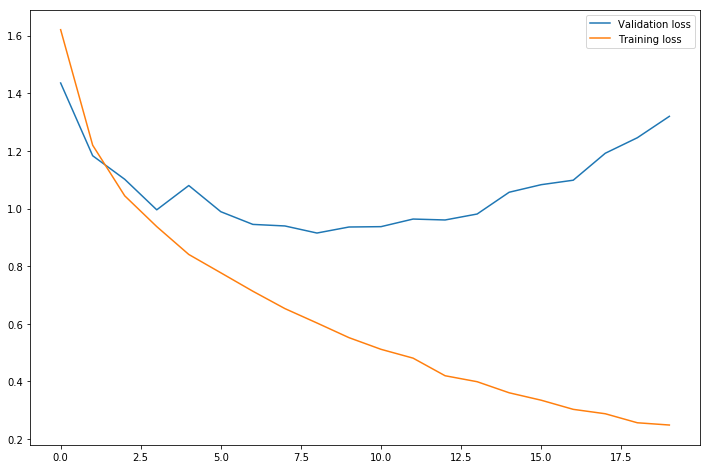

In [52]:
visualize_loss_history(model1_history)

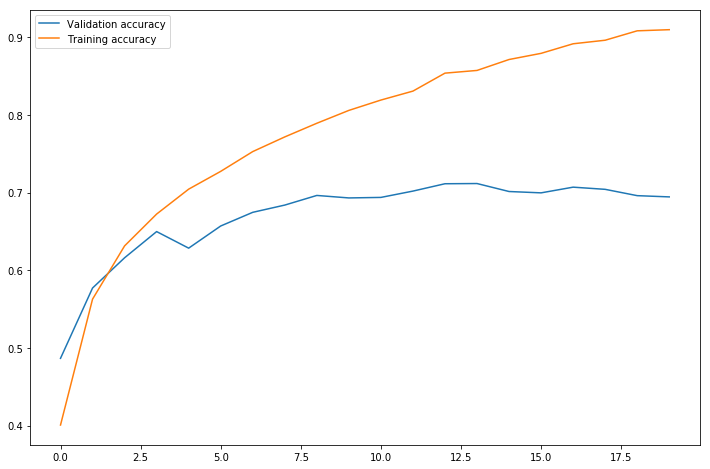

In [53]:
visualize_accuracy_history(model1_history)

After just a few iterations we can see clear signs of overfitting, and hugely diminished returns of further training. The network scores as expected 70% accuracy

### With data augmentation

In [32]:
batch_size = 64
epochs = 10

h = model1.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model1_history = join_histories(model1_history, h.history)
save_history(model1_history, "model1_history")
save_weights(model1, "model1")

Epoch 1/15
665/665 [==============================] - 19s 29ms/step - loss: 1.7212 - acc: 0.3591 - val_loss: 1.4434 - val_acc: 0.4703
Epoch 2/15
665/665 [==============================] - 15s 23ms/step - loss: 1.4165 - acc: 0.4802 - val_loss: 1.2686 - val_acc: 0.5525
Epoch 3/15
665/665 [==============================] - 15s 23ms/step - loss: 1.2858 - acc: 0.5369 - val_loss: 1.2065 - val_acc: 0.5825
Epoch 4/15
665/665 [==============================] - 15s 23ms/step - loss: 1.1923 - acc: 0.5734 - val_loss: 1.0528 - val_acc: 0.6321
Epoch 5/15
665/665 [==============================] - 15s 23ms/step - loss: 1.1252 - acc: 0.6004 - val_loss: 1.0267 - val_acc: 0.6436
Epoch 6/15
665/665 [==============================] - 15s 23ms/step - loss: 1.0589 - acc: 0.6197 - val_loss: 0.9538 - val_acc: 0.6683
Epoch 7/15
665/665 [==============================] - 15s 23ms/step - loss: 1.0216 - acc: 0.6358 - val_loss: 0.9600 - val_acc: 0.6669
Epoch 8/15
665/665 [==============================] - 15s 23ms

### Model evaluation and results

In [42]:
model1.load_weights("model1_1542800949.72.h5")
model1_history = load_history("model1_history_1542800949.72.json")

In [43]:
evaluate_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
__________

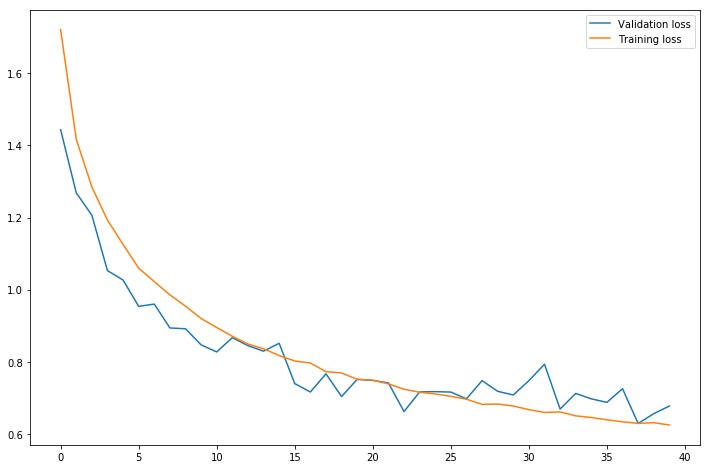

In [44]:
visualize_loss_history(model1_history)

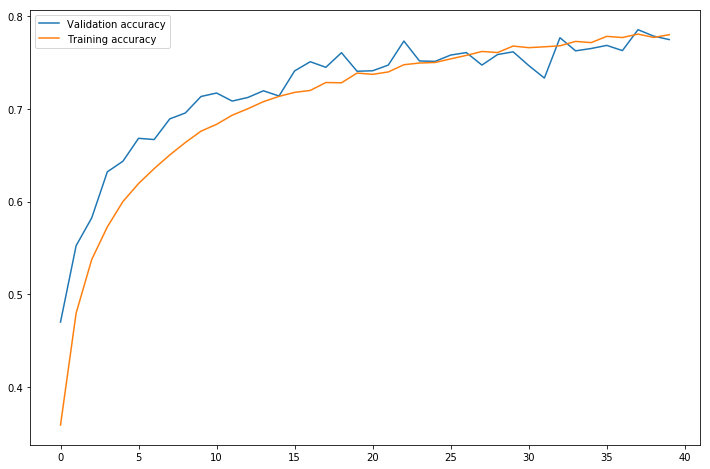

In [46]:
visualize_accuracy_history(model1_history)

After 40 iterations, we begin to observe reduced improvements in training, and are beginning to overfit, so we decided to stop training

The model achieves a test accuracy of 77.3% which is impressive considering the simplicity of the model.

Compared to no data augmentation, we were able to reduce overfitting, and gained an impressive 7% additional accuracy score.

### Training our MNIST model

In [21]:
model_mnist = tf.keras.models.Sequential()
model_mnist.add(tf.keras.layers.Flatten(input_shape=input_shape))
model_mnist.add(tf.keras.layers.Dense(784, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(512, activation="relu"))
model_mnist.add(tf.keras.layers.Dropout(0.40))
model_mnist.add(tf.keras.layers.Dense(512, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(512, activation="relu"))
model_mnist.add(tf.keras.layers.Dropout(0.50))
model_mnist.add(tf.keras.layers.Dense(256, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(128, activation="relu"))
model_mnist.add(tf.keras.layers.Dropout(0.40))
model_mnist.add(tf.keras.layers.Dense(128, activation="relu"))
model_mnist.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
opt = 'adam'

model_mnist.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_mnist_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [27]:
batch_size = 64
epochs = 10

h = model_mnist.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val_data, y_val_data),
                    shuffle=True)
model_mnist_history = join_histories(model_mnist_history, h.history)
save_history(model_mnist_history, "model_mnist_history")
save_weights(model_mnist, "model_mnist")

Epoch 1/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7196 - acc: 0.3864 - val_loss: 1.6407 - val_acc: 0.4128
Epoch 2/10
665/665 [==============================] - 14s 22ms/step - loss: 1.7146 - acc: 0.3881 - val_loss: 1.6003 - val_acc: 0.4155
Epoch 3/10
665/665 [==============================] - 14s 22ms/step - loss: 1.7148 - acc: 0.3877 - val_loss: 1.6448 - val_acc: 0.4083
Epoch 4/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7169 - acc: 0.3853 - val_loss: 1.6201 - val_acc: 0.4176
Epoch 5/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7208 - acc: 0.3824 - val_loss: 1.6237 - val_acc: 0.4249
Epoch 6/10
665/665 [==============================] - 15s 22ms/step - loss: 1.7183 - acc: 0.3850 - val_loss: 1.6243 - val_acc: 0.4176
Epoch 7/10
665/665 [==============================] - 14s 21ms/step - loss: 1.7124 - acc: 0.3891 - val_loss: 1.6346 - val_acc: 0.4096
Epoch 8/10
665/665 [==============================] - 15s 22ms

In [31]:
model_mnist.load_weights("model_mnist_1542808197.58.h5")
model_mnist_history = load_history("model_mnist_history_1542808197.58.json")

In [32]:
evaluate_model(model_mnist)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 784)               2409232   
_________________________________________________________________
dense_33 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
__________

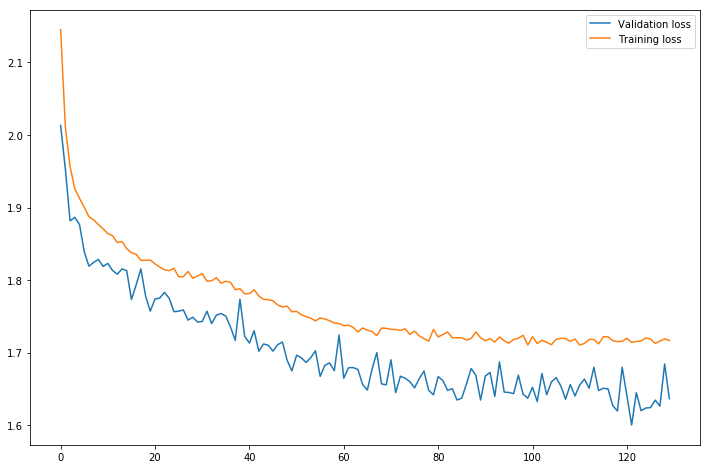

In [33]:
visualize_loss_history(model_mnist_history)

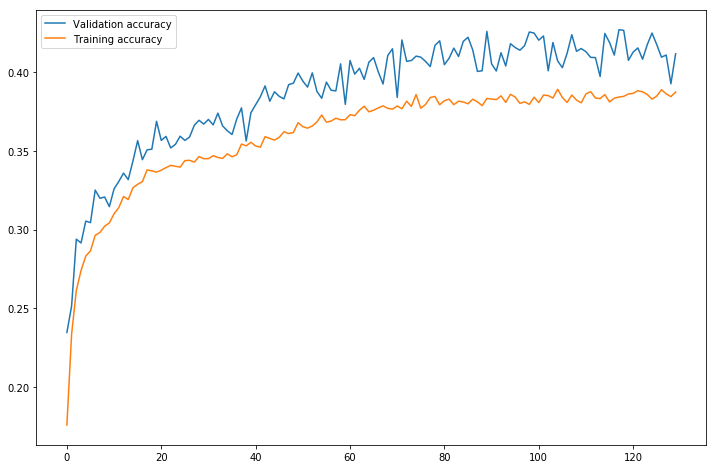

In [34]:
visualize_accuracy_history(model_mnist_history)

Our MNIST fully connected model did not perform as good on the CIFAR-10 dataset, with an accuracy score of 42.1%. This is probably due to the differences in the two datasets. The MNIST dataset consists of simple grayscale images of numbers, which contains only a few basic lines and shapes, in contrast to the CIFAR-10 dataset which consists of much more abstract shapes and objects. CNNs are far superior to fully connected networks when it comes to recognizing features, shapes and groups of shapes than a fully connected network, thus it would naturally perform better.

Furthermore we must take into consideration that the CIFAR-10 dataset consists of 3 channel rgb images, whereas the MNIST dataset only consists of 1 channel. When flattening the image in the MNIST model, we lose information about how the three layers are overlaying, this information is preserved in a convolutional network, thus making it easier to connect shapes across the color channels.

### Training a simple model
Looking at model1 which scored an accuracy of 77.3%, we use this as a base to create the simplest model achieving over 70%.

In [10]:
model_simple = tf.keras.models.Sequential()
model_simple.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model_simple.add(tf.keras.layers.MaxPool2D())
model_simple.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_simple.add(tf.keras.layers.MaxPool2D())
model_simple.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_simple.add(tf.keras.layers.MaxPool2D())

model_simple.add(tf.keras.layers.Flatten())
model_simple.add(tf.keras.layers.Dense(64, activation='relu'))
model_simple.add(tf.keras.layers.Dense(32, activation='relu'))
model_simple.add(tf.keras.layers.Dense(num_classes))
model_simple.add(tf.keras.layers.Activation('softmax'))

In [11]:
opt = 'adam'

model_simple.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_simple_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [42]:
batch_size = 64
epochs = 10

h = model_simple.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model_simple_history = join_histories(model_simple_history, h.history)
save_history(model_simple_history, "model_simple_history")
save_weights(model_simple, "model_simple")

Epoch 1/10
665/665 [==============================] - 15s 22ms/step - loss: 0.8805 - acc: 0.6897 - val_loss: 0.8676 - val_acc: 0.6981
Epoch 2/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8787 - acc: 0.6915 - val_loss: 0.8537 - val_acc: 0.7045
Epoch 3/10
665/665 [==============================] - 14s 22ms/step - loss: 0.8695 - acc: 0.6969 - val_loss: 0.8931 - val_acc: 0.6851
Epoch 4/10
665/665 [==============================] - 14s 22ms/step - loss: 0.8701 - acc: 0.6944 - val_loss: 0.8221 - val_acc: 0.7103
Epoch 5/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8720 - acc: 0.6947 - val_loss: 0.8568 - val_acc: 0.7000
Epoch 6/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8558 - acc: 0.7016 - val_loss: 0.8732 - val_acc: 0.6976
Epoch 7/10
665/665 [==============================] - 14s 21ms/step - loss: 0.8514 - acc: 0.7014 - val_loss: 0.8936 - val_acc: 0.6895
Epoch 8/10
665/665 [==============================] - 14s 21ms

In [46]:
model_simple.load_weights("model_simple_1542811046.2.h5")
model_simple_history = load_history("model_simple_history_1542811046.2.json")

In [47]:
evaluate_model(model_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
__________

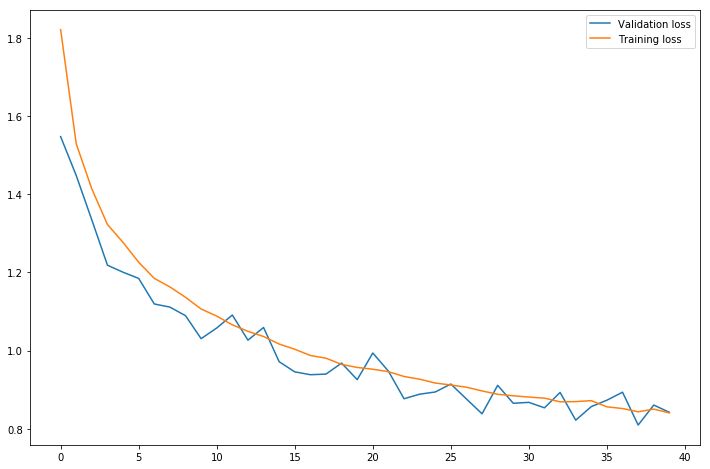

In [48]:
visualize_loss_history(model_simple_history)

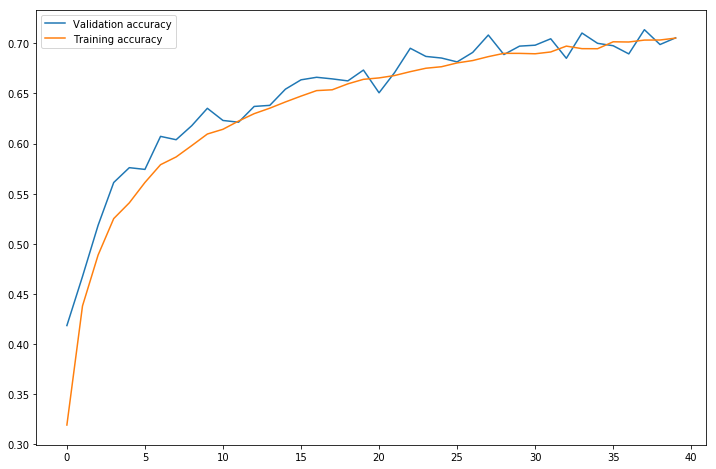

In [49]:
visualize_accuracy_history(model_simple_history)

Our simple model achieves 71.67% accuracy with only 42442 parameters. We stopped training after 40 iterations because we were seing reduced benefits and a tendency to overfit.

It might be possible to reduce this model even further, but we were not able to produce any stable results with a lower amount of parameters

## Model 3 - The highest accuracy
When attempting to reach the highest possible accuracy, we needed a reasonably complex model, while still not containing too many trainable parameters, due to the small size of our data set.

We decided to add in total 3 convolutional layers, doubling the filter count after each max pooling, which halves the image size. This way we don't loose too much data between each layer.

The kernel size was kept at (3, 3) because larger features are less important when the image size is so small.

The batch normalization layers normalizes the inputs for the hidden layers, and reduces the covariance shift, thus preventing overfitting.

We also used dropout layers to prevent overfitting.

The tail of the network is a fully connected classifier, taking the features from the convolution and classifying them into objects.

In [26]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(32, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())

model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(tf.keras.layers.BatchNormalization())

model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())
           
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(256))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Dense(128))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(64))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dense(num_classes))
model3.add(tf.keras.layers.Activation('softmax'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
__________

The total amount of parameters is 624,298 which is a bit on the higher end, but with data aumgentation and enough epochs we should be able to get a good result

In [57]:
opt = 'adam'

model3.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model3_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [77]:
epochs = 200

h = model3.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model3_history = join_histories(model3_history, h.history)
save_history(model3_history, "model3_history")
save_weights(model3, "model3")

Epoch 1/200
665/665 [==============================] - 16s 24ms/step - loss: 0.7232 - acc: 0.7581 - val_loss: 0.7617 - val_acc: 0.7427
Epoch 2/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7263 - acc: 0.7570 - val_loss: 0.7232 - val_acc: 0.7528
Epoch 3/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7143 - acc: 0.7618 - val_loss: 0.7207 - val_acc: 0.7548
Epoch 4/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7037 - acc: 0.7659 - val_loss: 0.7085 - val_acc: 0.7645
Epoch 5/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7130 - acc: 0.7645 - val_loss: 0.8684 - val_acc: 0.7152
Epoch 6/200
665/665 [==============================] - 15s 23ms/step - loss: 0.6906 - acc: 0.7712 - val_loss: 0.7262 - val_acc: 0.7579
Epoch 7/200
665/665 [==============================] - 15s 23ms/step - loss: 0.6846 - acc: 0.7702 - val_loss: 0.6514 - val_acc: 0.7803
Epoch 8/200
665/665 [==============================] - 

665/665 [==============================] - 16s 24ms/step - loss: 0.4544 - acc: 0.8495 - val_loss: 0.5086 - val_acc: 0.8300
Epoch 122/200
665/665 [==============================] - 16s 25ms/step - loss: 0.4509 - acc: 0.8501 - val_loss: 0.5824 - val_acc: 0.8127
Epoch 123/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4538 - acc: 0.8532 - val_loss: 0.5263 - val_acc: 0.8261
Epoch 124/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4579 - acc: 0.8493 - val_loss: 0.5639 - val_acc: 0.8157
Epoch 125/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4619 - acc: 0.8457 - val_loss: 0.5311 - val_acc: 0.8259
Epoch 126/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4581 - acc: 0.8488 - val_loss: 0.5537 - val_acc: 0.8132
Epoch 127/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4571 - acc: 0.8519 - val_loss: 0.6606 - val_acc: 0.7875
Epoch 128/200
665/665 [==============================] 

In [91]:
evaluate_model(model3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
__________

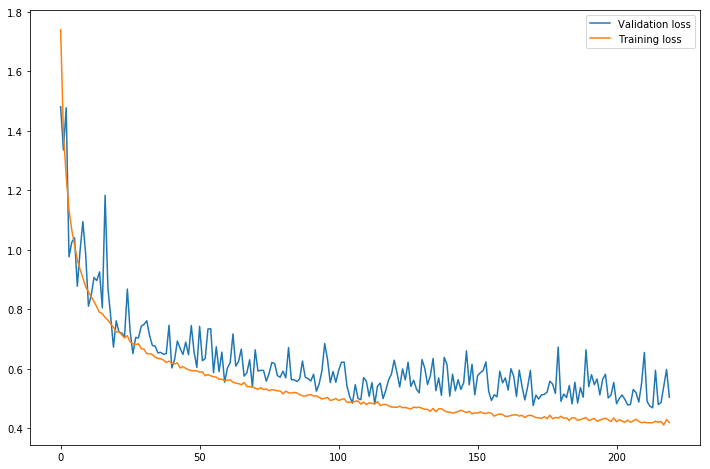

In [92]:
visualize_loss_history(model3_history)

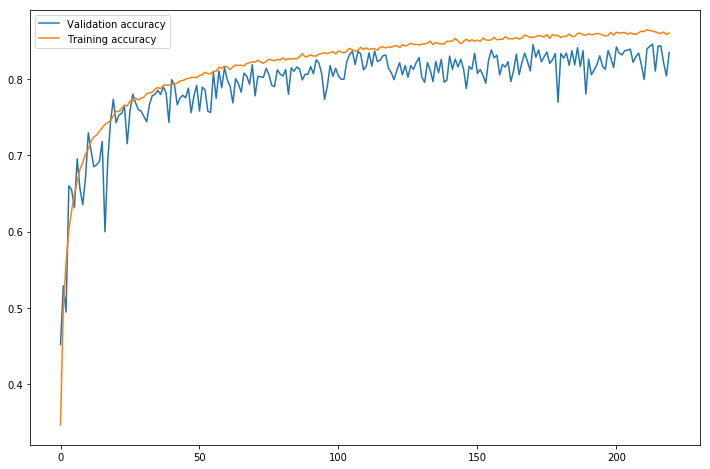

In [93]:
visualize_accuracy_history(model3_history)

We stopped the training after 200 epochs after observing diminishing returns and tendencies to overfitting.

Our model achieves an accuracy of 83.48% with 624,298 parameters, which is good compared to the complexity of the network.

In comparison, model 1 scored 77% with 160k parameters, so gaining another 6% with a four times increase in parameters is a reasonable tradeoff.

## Transfer learning
### Model definition
Our model is based on the VGG16 model pretrained on the ImageNet dataset. We exclude the top classifier layer.

In [10]:
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                              weights='imagenet',
                                              input_shape=x_train_data.shape[1:])

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

The CIFAR-10 problem and ImageNet problem are both object classification problems, and the datasets are similar, both consisting of simple rgb images. The first layers in the model, which detect simple features and shapes will most likely be very generic, and can work equally well on both datasets. Thus we can lock these layers when training.

Furthermore, the classes covered by CIFAR-10 are also covered by ImageNet, so we can assume that the model trained on the ImageNet should be able to recognize the main features composing the objects in CIFAR-10. Because of this, we are able to lock the middle layers when training, because these are the ones recognizing groups and abstract collections of features.

In our CIFAR-10 dataset we have 42500 training images, which compared to the 1.2 million images in the ImageNet dataset is not very much. Thus we should try to not modify too many parameters in the pretrained network, by lowering the trainable parameter count and also reducing the learning rate. However, the number of images per class is higher for CIFAR-10 compared to ImageNet, so we should be able to train a fair amount of the parameters in the last layers of the network.

Consequently we only enable training on the last convolutional layer in the network.

In [12]:
# Disable training on all layers except the last convolutional layer.
for layer in vgg_model.layers[:-2]:
    layer.trainable = False

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

The last layer of the VGG16 model is now trainable, with 2,359,808 parameters

We now train a new classification layer for the 10 classes in our data set. The dense layer has 512 nodes because this is the output size of the VGG network.

In [13]:
model_t = tf.keras.models.Sequential()
model_t.add(vgg_model)
model_t.add(tf.keras.layers.Flatten())
model_t.add(tf.keras.layers.Dense(512, activation="relu"))
model_t.add(tf.keras.layers.Dropout(0.2))
model_t.add(tf.keras.layers.Dense(10, activation="softmax"))
model_t.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 2,627,594
Non-trainable params: 12,354,880
_________________________________________________________________


This brings our trainable parameter count to 2,627,594 which is a bit high given the size of our data set, but if we reduce the learning rate combined with data augmentation it should work fine

In [15]:
opt = tf.keras.optimizers.Adam(lr=0.0002)

model_t.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_t_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

# checkpoint
filepath="transfer-vgg16-chkpnt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

In [30]:
batch_size = 32
epochs = 10

h = model_t.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(x_val_data, y_val_data),
                             callbacks=callbacks_list,
                             shuffle=True)

model_t_history = join_histories(model_t_history, h.history)
save_history(model_t_history, "model_t_history")
save_weights(model_t, "model_t")

Epoch 1/10
1326/1329 [============================>.] - ETA: 0s - loss: 0.6692 - acc: 0.7619
Epoch 00001: val_acc did not improve from 0.68480
1329/1329 [==============================] - 24s 18ms/step - loss: 0.6693 - acc: 0.7619 - val_loss: 1.0073 - val_acc: 0.6763
Epoch 2/10
1327/1329 [============================>.] - ETA: 0s - loss: 0.6624 - acc: 0.7635
Epoch 00002: val_acc improved from 0.68480 to 0.68587, saving model to transfer-vgg16-chkpnt-002-0.69.hdf5
1329/1329 [==============================] - 25s 19ms/step - loss: 0.6623 - acc: 0.7635 - val_loss: 0.9671 - val_acc: 0.6859
Epoch 3/10
1326/1329 [============================>.] - ETA: 0s - loss: 0.6489 - acc: 0.7679
Epoch 00003: val_acc improved from 0.68587 to 0.69107, saving model to transfer-vgg16-chkpnt-003-0.69.hdf5
1329/1329 [==============================] - 25s 18ms/step - loss: 0.6487 - acc: 0.7679 - val_loss: 0.9580 - val_acc: 0.6911
Epoch 4/10
1326/1329 [============================>.] - ETA: 0s - loss: 0.6507 - a

In [34]:
model_t.load_weights("model_t_1542815307.92.h5")
model_t_history = load_history("model_t_history_1542815307.92.json")

In [35]:
evaluate_model(model_t)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 2,627,594
Non-trainable params: 12,354,880
_________________________________________________________________
10000/10000 [==============================] - 3s 340us/step
Test loss: 0.9873, accuracy: 0.6918


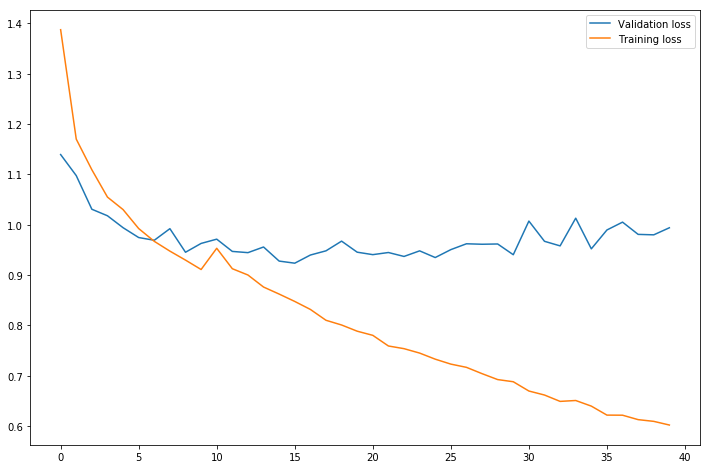

In [36]:
visualize_loss_history(model_t_history)

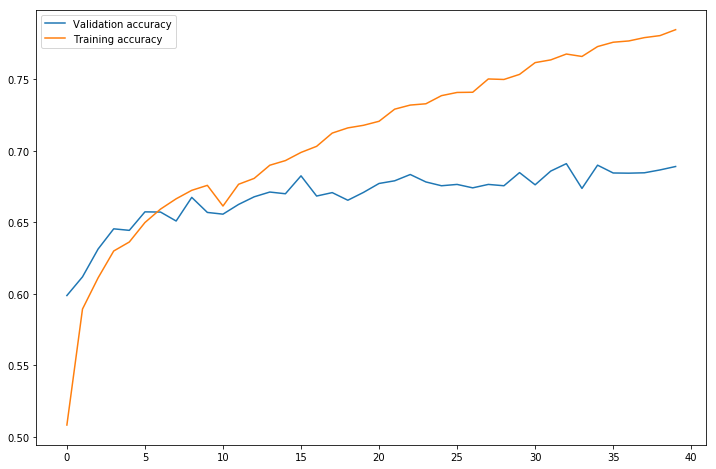

In [38]:
visualize_accuracy_history(model_t_history)

We decided to stop training here due to diminishing results and clear signs of overfitting, although the overall trend of the validation accuracy is increasing, though rather slowly.

A result of 69.18% accuracy is underwhelming considering the complexity of the network, however not unexpected.

The low accuracy could be a result of lack of training, however it is more likely the differences in the already pretrained part of the network. The images in ImageNet are 224x224 and consequently the pretrained network might be trained to look for larger features, than the small features in our 32x32 images.

Our data set size is also too small compared to the number of parameters, even with data augmentation, so it's difficult to train the network properly.